# Configuración Inicial

## Habilitar GPU (solo para Google Colab)

En la barra superior:

1.   Entorno de ejecución
2.   Cambiar tipo de entorno de ejecución -> GPU


## Subir *dataset* (solo para Google Colab)

In [1]:
### QUITAR COMENTARIOS Y EJECUTAR PARA USAR EN GOOGLE COLAB ###
#from google.colab import files

#uploaded = files.upload()  # Seleccionar el archivo desde el sistema local

# 1 Procesamiento de datos

## 1.1 Carga y exploración inicial

### 1.1.1 Carga del dataset y visualización inicial

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset
df = pd.read_csv("Housing.csv")  # Asegurarse de tener el archivo en el directorio local, o subirlo manualmente a Google Colab

In [3]:
# Visualizar primeras filas
print("Primeras 5 filas:")
print(df.head())

# Verificar valores nulos
print("\nValores faltantes por columna:")
df.isnull().sum()

Primeras 5 filas:
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  

Valores faltantes por columna:


price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

No hay valores faltantes en ninguna columna. Por tanto, no es necesario hacer tratamiento de valores nulos.

### 1.1.2 Análisis de distribuciones y outliers

Graficar histogramas y diagramas de caja:

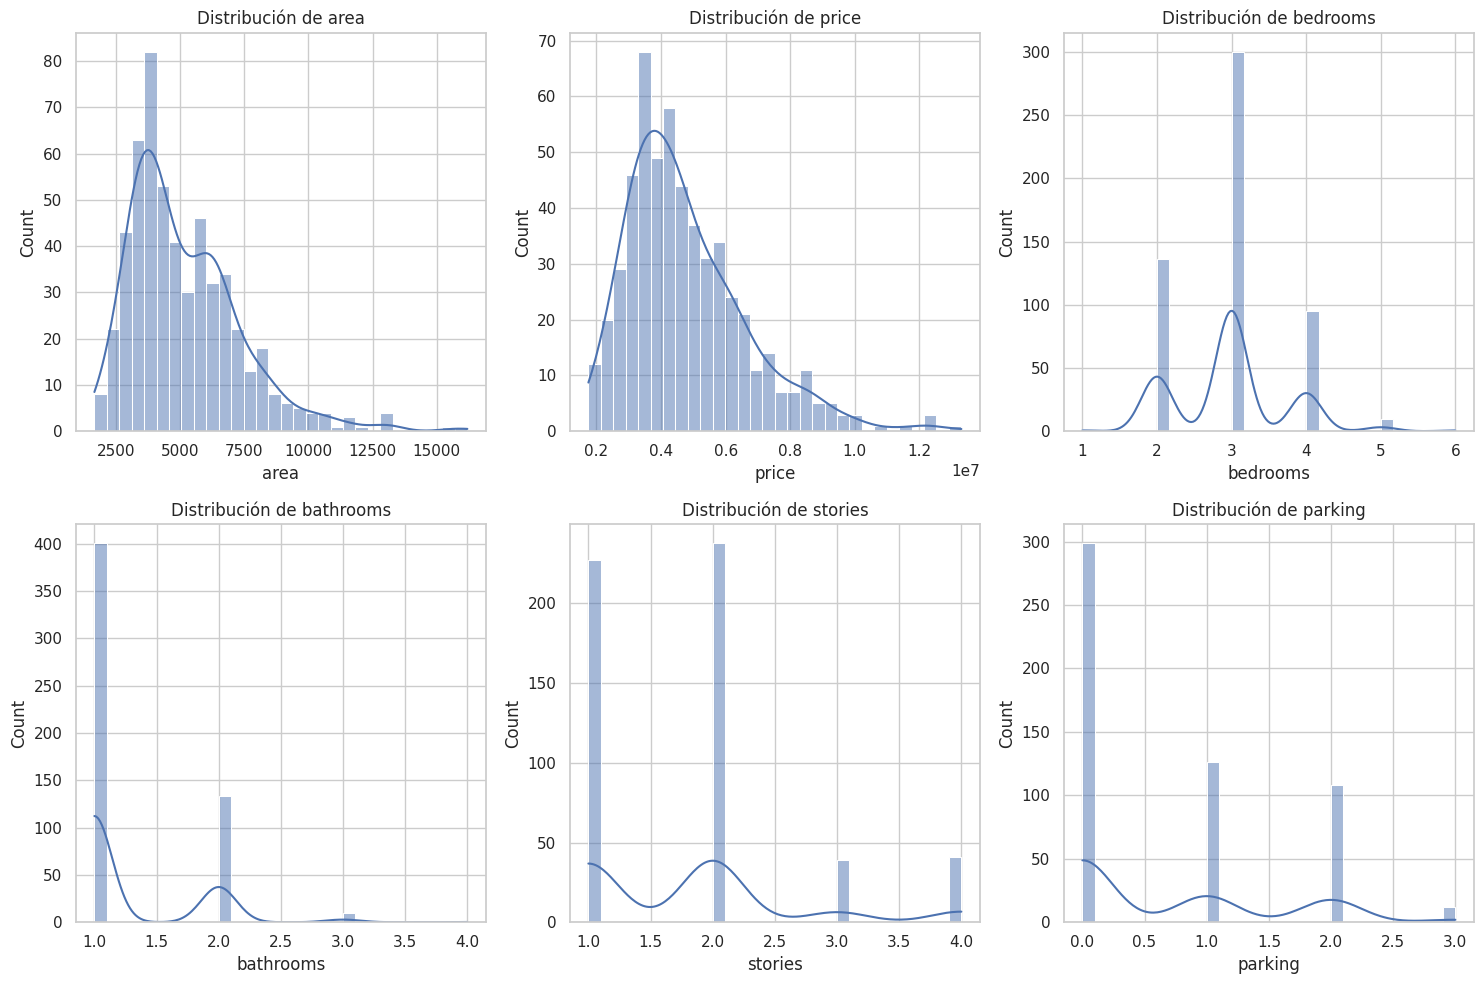

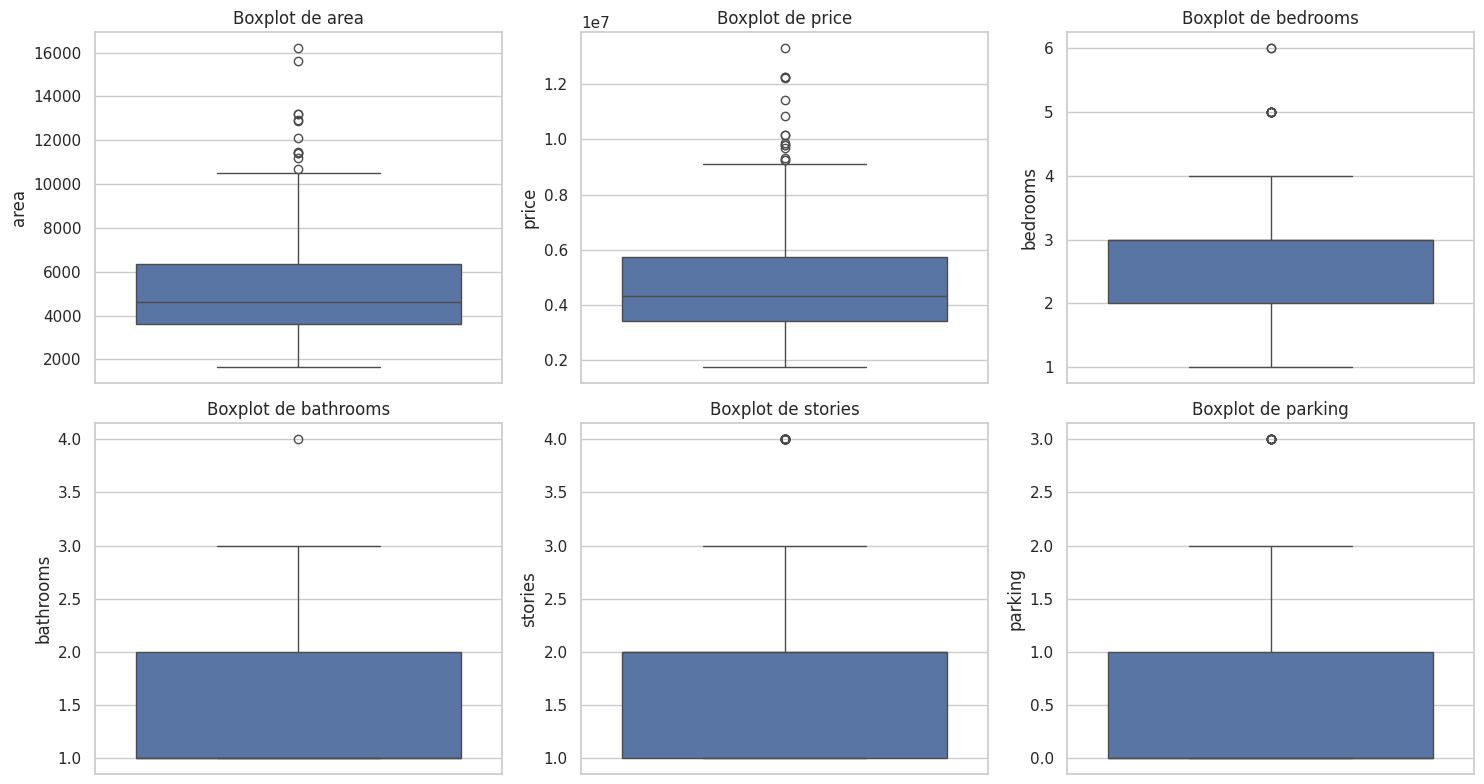

In [4]:
# Configurar estilo de gráficos
sns.set_theme(style="whitegrid")

# Histogramas para variables numéricas
numerical_cols = ['area', 'price', 'bedrooms', 'bathrooms', 'stories', 'parking']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribución de {col}')
plt.tight_layout()
plt.show()

# Boxplots para detectar outliers
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot de {col}')
plt.tight_layout()
plt.show()

- **Histogramas**:

    Muestran la distribución de cada variable numérica.

    Si la distribución tiene una cola larga a la derecha (**sesgo positivo**), significa que hay valores extremadamente altos. En este caso, sucede con `area` y `price`.

- **Boxplots**:

    Identifican valores **atípicos** (_outliers_) en cada variable.

    Los puntos fuera de los "bigotes" (líneas horizontales) son _outliers_. De nuevo, `area` y `price` tienen varios, lo que sugiere que hay propiedades con áreas mucho más grandes que el resto, y con un precio también mucho mayor a los demás.

## 1.2 Preprocesamiento de datos

### 1.2.1 Codificación de variables categóricas

- **Binarias**: `1` para "_yes_", `0` para "_no_".

- ¿Por qué es mejor One-Hot Encoding que Label Encoding en este caso?

    1. Evita jerarquías artificiales:

        La red neuronal podría interpretar erróneamente que unfurnished (0) < semi-furnished (1) < furnished (2), lo que no necesariamente refleja la realidad en los precios.

    2. Flexibilidad del modelo:

        Con One-Hot, cada categoría se trata como una característica independiente, permitiendo al modelo aprender contribuciones no lineales.

    3. Ejemplo práctico:

        Una propiedad semi-furnished no es el "punto medio" entre unfurnished y furnished en términos de precio. One-Hot captura mejor esta relación.

In [5]:
# Variables binarias (yes/no)
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
df[binary_cols] = df[binary_cols].replace({'yes': 1, 'no': 0})

# One-Hot Encoding para furnishingstatus
df = pd.get_dummies(df, columns=['furnishingstatus'], prefix='furnishing', dtype=int)

/tmp/ipykernel_30954/56217782.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[binary_cols] = df[binary_cols].replace({'yes': 1, 'no': 0})


In [6]:
# Verificar cambios
df.head(10)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishing_furnished,furnishing_semi-furnished,furnishing_unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,0,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1,0,0
5,10850000,7500,3,3,1,1,0,1,0,1,2,1,0,1,0
6,10150000,8580,4,3,4,1,0,0,0,1,2,1,0,1,0
7,10150000,16200,5,3,2,1,0,0,0,0,0,0,0,0,1
8,9870000,8100,4,1,2,1,1,1,0,1,2,1,1,0,0
9,9800000,5750,3,2,4,1,1,0,0,1,1,1,0,0,1


### 1.2.2 Normalización de Variables Numéricas

`StandardScaler` centra las variables en 0 con **desviación estándar** 1. De esta forma, evita que variables como `area` (valores grandes) dominen el modelo.

In [7]:
from sklearn.preprocessing import StandardScaler

# Separar variables numéricas
numerical_cols = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
X_numerical = df[numerical_cols]

# Escalado (usando StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numerical)

# Reemplazar columnas originales con valores escalados
df[numerical_cols] = X_scaled

In [8]:
# Verificar cambios
df[numerical_cols].head()

,area,bedrooms,bathrooms,stories,parking
0,1.046726,1.403419,1.421812,1.378217,1.517692
1,1.757010,1.403419,5.405809,2.532024,2.679409
2,2.218232,0.047278,1.421812,0.224410,1.517692
3,1.083624,1.403419,1.421812,0.224410,2.679409
4,1.046726,1.403419,-0.570187,0.224410,1.517692


## 1.3 Análisis de correlación

### 1.3.1 Matriz de correlación

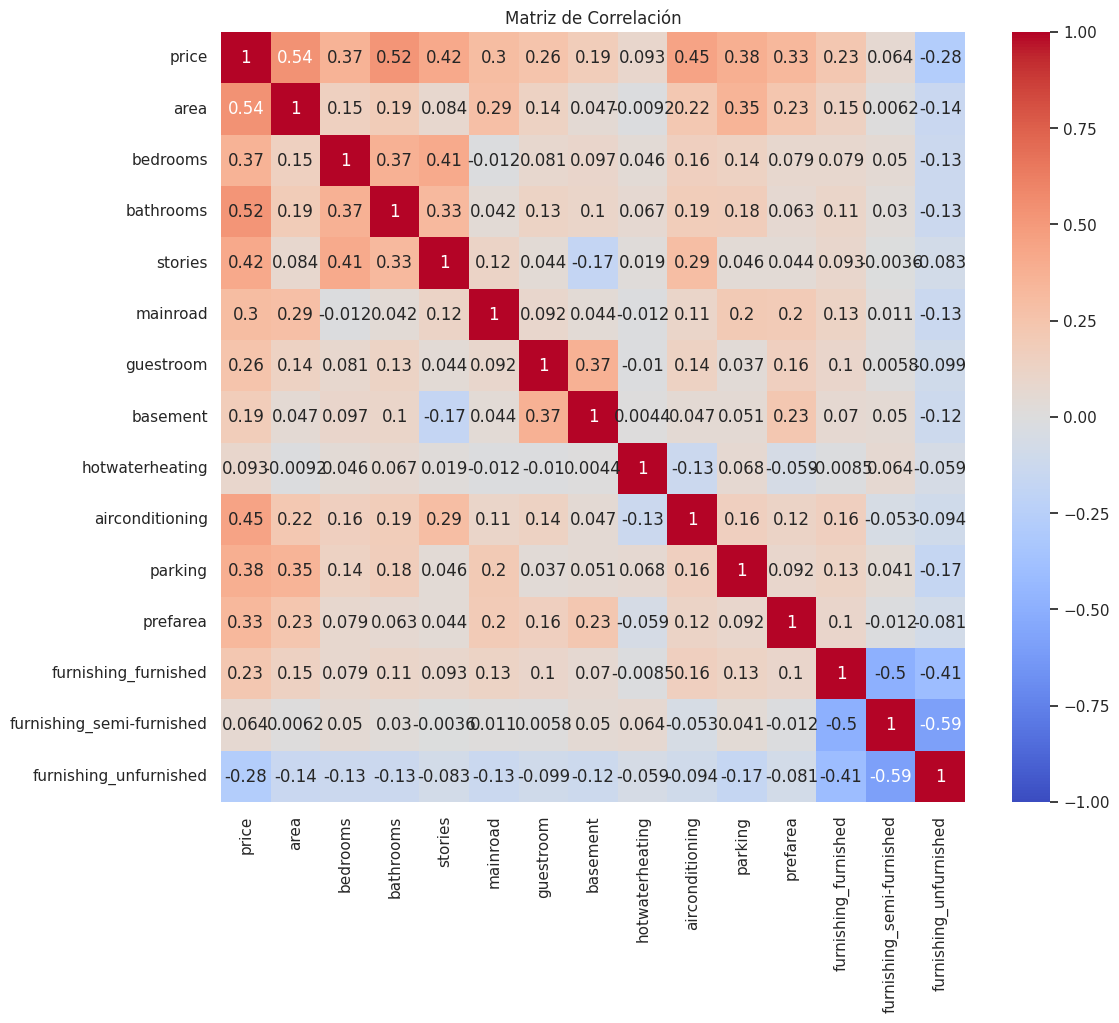

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular matriz de correlación
corr_matrix = df.corr()

# Matriz de correlación para todas las variables
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matriz de Correlación")
plt.show()

También se puede evaluar sólo la columna de la **matriz de correlación** en función de `price`:

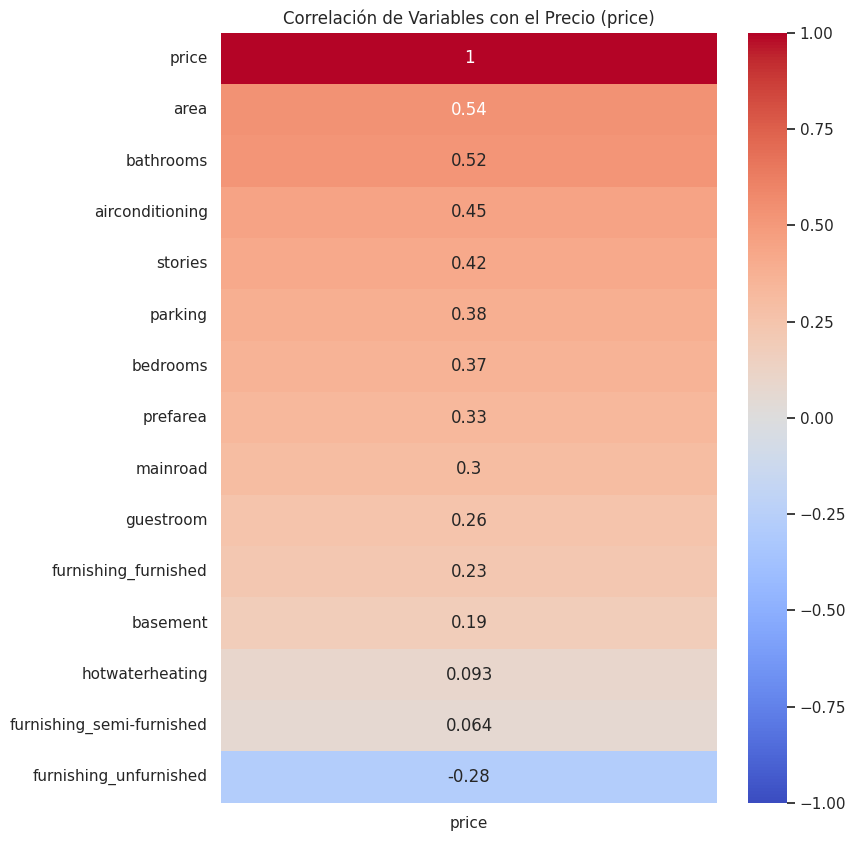

In [10]:
# Filtrar solo las correlaciones con 'price'
price_corr = corr_matrix[['price']].sort_values(by='price', ascending=False)

# Gráfico de correlaciones con 'price'
plt.figure(figsize=(8, 10))
sns.heatmap(price_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlación de Variables con el Precio (price)")
plt.show()

Variables Fuertemente Correlacionadas con `price`:

- Alta correlación **positiva** (`> 0.4`): `area`, `bathrooms`, `airconditioning`: A mayor área, número de baños y/o con aire acondicionado, mayor precio.

- Correlación **negativa** (`< -0.3`): `furnishing_unfurnished`: Las propiedades no amuebladas tienden a ser más baratas.

- **Poca** o casi ninguna correlación:

    - `hotwaterheating` (`0.093`): Saber si una casa tiene o no agua caliente, aporta muy poca información sobre el precio de la misma.

    - `furnishing_semi-furnished` (`0.064`): Que una casa esté "semiamueblada" tiene un impacto mínimo en el precio.

### 1.3.2 Eliminación de variables

Con la información que se ha obtenido al realizar el análisis anterior, se pueden sacar las siguientes **conclusiones**:

- `hotwaterheating`: Se puede **eliminar** esta columna, ya que su correlación con `price` es muy baja, y no aporta información significativa al modelo.

- `furnishing_semi-furnished`: **No** se va a eliminar esta columna, ya que podría carecer de lógica que una vivienda tuviera valor 0 en las otras dos categorías de `furnishing`.

In [11]:
# Eliminar la columna hotwaterheating
df.drop('hotwaterheating', axis=1, inplace=True)

# Verificar el dataset actualizado
df.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'airconditioning', 'parking', 'prefarea',
       'furnishing_furnished', 'furnishing_semi-furnished',
       'furnishing_unfurnished'],
      dtype='object')

## 1.4 Creación de datos sintéticos (_data augmentation_)

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split

# Separar características (X) y variable objetivo (y)
X = df.drop('price', axis=1)  # Todas las columnas excepto 'price'
y = df['price']  # Columna 'price' como variable objetivo

def augment_data(X, y, num_samples=1000):
    np.random.seed(42)
    
    # Interpolación entre puntos reales
    idx1 = np.random.randint(0, len(X), num_samples)
    idx2 = np.random.randint(0, len(X), num_samples)
    
    alpha = np.random.uniform(0, 1, num_samples).reshape(-1, 1)
    X_aug = alpha * X.iloc[idx1].values + (1 - alpha) * X.iloc[idx2].values
    y_aug = alpha.flatten() * y.iloc[idx1].values + (1 - alpha.flatten()) * y.iloc[idx2].values
    
    # Agregar ruido gaussiano
    noise_X = np.random.normal(0, 0.01, X_aug.shape)
    noise_y = np.random.normal(0, 0.01, y_aug.shape)
    
    X_aug += noise_X
    y_aug += noise_y
    
    X_aug = pd.DataFrame(X_aug, columns=X.columns)
    y_aug = pd.Series(y_aug, name=y.name)
    
    return X_aug, y_aug

# Aplicar aumentación
X_aug, y_aug = augment_data(X, y, num_samples=500)
X = pd.concat([X, X_aug], axis=0)
y = pd.concat([y, y_aug], axis=0)

## 1.5 División Train-Test

Se utiliza `train_test_split` para dividir el conjunto de datos en 80% datos de entrenamiento y 20% datos de prueba.

In [13]:
# División: 80% entrenamiento, 20% prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Verificar tamaños de los conjuntos
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

Tamaño del conjunto de entrenamiento: (836, 13)
Tamaño del conjunto de prueba: (209, 13)


# 2 Model Planning

Asegurarse de que `TensorFlow` esté usando la GPU:

In [15]:
import tensorflow as tf

print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

2025-03-24 10:04:09.303904: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 10:04:09.355525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742807049.373257   30954 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742807049.379294   30954 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742807049.407678   30954 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2.1 Definición de la arquitectura del modelo

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Definir el modelo
model = Sequential([
    Dense(64, activation='relu', input_shape=(13,)),  # Capa de entrada y oculta 1
    Dropout(0.2),  # Regularización para evitar sobreajuste
    Dense(32, activation='relu'),  # Capa oculta 2
    Dense(1)  # Capa de salida (predicción del precio)
])

# Compilar el modelo
model.compile(
    optimizer='adam',  # Optimizador Adam
    loss='mse',        # Error cuadrático medio (MSE)
    metrics=['mae']    # Error absoluto medio (MAE) para monitorear
)

/mnt/c/Users/aleja/Desktop/Master/05 - IA Generativa/Desarrollo/CasoEstudio-Housing/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1742807068.445380   30954 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3620 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Verificación de la arquitectura:

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,945 (11.50 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 0 (0.00 B)